<a href="https://colab.research.google.com/github/tejaswishetty17/Agentic-AI/blob/main/Calling_Agents_7(Using%20sqlite3%20db%20to%20store%20chats).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



> Storing conversation data on sqlite db instead of memory, so we can access it through sessions



In [1]:
pip install -q langchain langchain_openai langchain_community langgraph langchain-core langgraph-checkpoint-sqlite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.5/64.5 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.6/151.6 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 8.6 MB/s eta 0:00:00


In [2]:
import os
os.environ["OPENAI_API_KEY"] = ""

In [3]:
import sqlite3
#In memory
conn = sqlite3.connect(":memory", check_same_thread = False)

> If we specify the db path, it will create a database for us!



In [4]:
import sqlite3
sqlite3.connect("my_database2.db")

In [5]:
db_path = "my_database2.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

In [6]:
#Here is the our checkpointer
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver(conn)

Let's re-define our chatbot.

In [7]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langgraph.graph import MessagesState
from langgraph.graph import END

model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

class State(MessagesState):
  summary:str


#Define the logic to call the model
def call_model(state: State) -> State:

  #get summary if it exists
  summary = state.get("summary", "")

  #If there is summmary, then we do this
  if summary:

    #Add summary to system message
    system_message = f"Summary of conversation earlier: {summary}"

    #Apend summary to any newer messages
    messages = [SystemMessage(content=system_message)] + state["messages"]

  else:
    messages = state["messages"]

  response = model.invoke(messages)
  return {"messages":response}

def summarize_conversation(state: State)-> State:

  #First, we get any existing summary
  summary = state.get("summary", "")

  #Create our summarization prompt
  if summary:

    # if summary already exists
    summary_message = (
        f"This is summary of the conversation to date: {summary}\n\n"
        "Extend the summary by taking into account the new messages above:"
    )
  else:
    summary_message = "Create a summary of the conversation above:"

  #Add prompt to our history
  messages = state["messages"] + [HumanMessage(content=summary_message)]
  response = model.invoke(messages)

  #Delete all but the 2 most recent messages
  delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
  return {"summary": response.content, "messages":delete_messages}


#Determine whether to end or summarize the conversation
def should_continue(state: State):
  """Return the next node to execute. """

  messages = state["messages"]

  # If there are more than six messages, then we summarize the conversation
  if len(messages)>6:
    return "summarize_conversation"
  # Otherwise we can just end
  return END

Now, we just re-complie with our sqlite checkpointer.

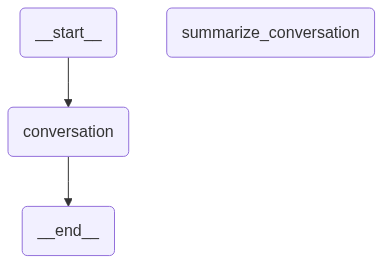

In [8]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
#create a thread
config = {"configurable": {"thread_id":"1"}}

#State conversation
input_message = HumanMessage(content = "Hi! I am Tejaswi")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
  m.pretty_print()

input_message = HumanMessage(content = "What is the LLM?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
  m.pretty_print()

input_message = HumanMessage(content = "I would like to know more about the use cases of LLM?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
  m.pretty_print()

================================== Ai Message ==================================

Hi Tejaswi! How can I assist you today?
================================== Ai Message ==================================

LLM stands for "Large Language Model." It refers to a type of artificial intelligence model that is trained on vast amounts of text data to understand and generate human-like language. These models use deep learning techniques, particularly neural networks, to process and generate text based on the patterns they learn during training.

Some key features of LLMs include:

1. **Natural Language Understanding**: They can comprehend and respond to text inputs in a way that mimics human conversation.

2. **Text Generation**: LLMs can generate coherent and contextually relevant text, making them useful for applications like chatbots, content creation, and more.

3. **Versatility**: They can perform a variety of language-related tasks, such as translation, summarization, question answering, a

In [10]:
config = {"configurable": {"thread_id":"1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content='Hi! I am Tejaswi', additional_kwargs={}, response_metadata={}, id='c9ddb90b-55e3-4050-bbec-28fd21eaad87'), AIMessage(content='Hi Tejaswi! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 14, 'total_tokens': 26, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BfOMR5uMDySy1u31TpbxjDwRQUTj1', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--bc4e2aed-107a-40aa-bd87-3677a564ed99-0', usage_metadata={'input_tokens': 14, 'output_tokens': 12, 'total_tokens': 26, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}


> Persisting state


Using database like Sqlite means state is persisted!

For example, we can re-start the notebook kernel and see that we can still load from Sqlite DB on disk.

In [11]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content='Hi! I am Tejaswi', additional_kwargs={}, response_metadata={}, id='c9ddb90b-55e3-4050-bbec-28fd21eaad87'), AIMessage(content='Hi Tejaswi! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 14, 'total_tokens': 26, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BfOMR5uMDySy1u31TpbxjDwRQUTj1', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--bc4e2aed-107a-40aa-bd87-3677a564ed99-0', usage_metadata={'input_tokens': 14, 'output_tokens': 12, 'total_tokens': 26, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}